# Image captioning without using attention


## Data preparation

### Download dataset

Register an account at https://www.kaggle.com/, create your API token and upload to the root directory (/content/).

In [ ]:
! pip install kaggle
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Download the target dataset and extract the zipped image and caption files.

In [7]:
! kaggle datasets download adityajn105/flickr8k
! unzip flickr8k.zip

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 98% 1.02G/1.04G [00:07<00:00, 220MB/s]
100% 1.04G/1.04G [00:07<00:00, 150MB/s]


Check the images and captions are correctly extracted.

In [12]:
! ls Images | wc -l

8091


In [ ]:
import pandas as pd
image_captions = pd.read_csv('captions.txt')
image_captions.shape
image_captions.sample(5)

### Preprocess

In [17]:
import os
import spacy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchtext
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models

from PIL import Image
from collections import Counter

from torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

Device is defined for acceleration of training.

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda', index=0)

Load tokeniser from torchtext library and counter is instantiated.

In [32]:
tokenizer = get_tokenizer('basic_english')

counter = Counter()

Build the vocabulary for captions using torchtext.

In [24]:
for line in image_captions['caption'].tolist():
    counter.update(tokenizer(line))

vocab = vocab(counter, min_freq = 5)

Special tokens are added and default index is set as UNK.

In [29]:
unk_token = '<unk>'
pad_token = '<pad>'
sos_token = '<sos>'
eos_token = '<eos>'

vocab.insert_token(unk_token, 0)
vocab.insert_token(pad_token, 1)
vocab.insert_token(sos_token, 2)
vocab.insert_token(eos_token, 3)

vocab.set_default_index(vocab['<unk>'])

In [38]:
len(vocab)

3005

Dataset is defined and get_item method returns Images with their  captions tokens in integer form(token ids)

In [39]:
class FlickrDataset(Dataset):

    def __init__(self, root_dir, captions_file, vocab, transform = None):

        self.root_dir = root_dir
        self.transform = transform
        self.vocab = vocab

        df = pd.read_csv(captions_file)

        self.length = len(df)

        self.captions = df['caption']
        self.img_names = df['image']

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        caption = self.captions[idx]
        img_name = self.img_names[idx]

        img_location = os.path.join(self.root_dir, img_name)
        img = Image.open(img_location).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        caption_text_to_index = lambda x: [self.vocab[token] for token in tokenizer(x)]

        caption_vec = []
        caption_vec += [vocab['<sos>']]
        caption_vec +=  caption_text_to_index(caption)
        caption_vec += [vocab['<eos>']]

        return img, torch.tensor(caption_vec)

Data collation in the form of batches is defined with required padded sequences for captions

In [40]:
class generate_batch_captions:

    def __init__(self, pad_idx, batch_first = False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self, batch):

        # Each batch (image_tensor, caption_tensor)

        # image_tensor = [batch_size, num_channels, height, width]
        # caption_tensor = [batch_size, num_words_in_caption]

        # Add an extra dimension of size 1 at index 0
        # [num_channels, height, width] -> [1, num_channels, height, width]
        imgs = [item[0].unsqueeze(0) for item in batch]

        imgs = torch.cat(imgs, dim = 0)

        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first = self.batch_first, padding_value = self.pad_idx)

        return imgs, targets

Helper function to plot the image. Note that images are unnormalised

In [41]:
def display_image(inp_img, title = 'Image'):

    inp_img[0] = inp_img[0] * 0.229
    inp_img[1] = inp_img[1] * 0.224
    inp_img[2] = inp_img[2] * 0.225

    inp_img[0] += 0.485
    inp_img[1] += 0.456
    inp_img[2] += 0.406

    inp_img = inp_img.numpy().transpose((1, 2, 0))
    plt.imshow(inp_img)
    plt.title(title)

    plt.pause(0.001)

Transformation for image is defined. After resizing, random cropping, conversion to tensor, normalisation is done and one random image is shown with captions and their token ids.

In [47]:
transforms = T.Compose([
    T.Resize(226),
    T.RandomCrop(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # mean and standard deviation of the ImageNet dataset
])


flickr_dataset =  FlickrDataset(
    root_dir = '/content/Images',
    captions_file = '/content/captions.txt',
    vocab = vocab,
    transform = transforms
)

In [43]:
len(flickr_dataset)

40455

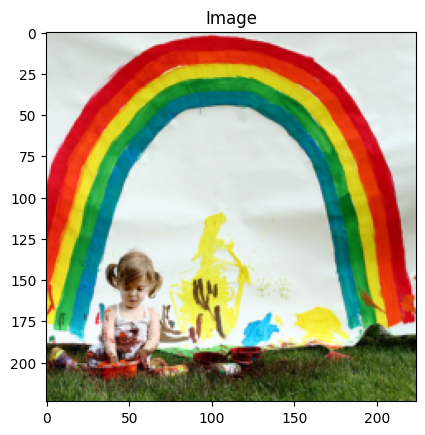

Token_ids: tensor([ 2,  4, 23, 18, 55,  6, 56, 57,  6, 58, 13,  4, 59, 60, 36, 27, 61,  6,
         4, 62, 17,  3])
Caption :
['<sos>', 'a', 'little', 'girl', 'covered', 'in', 'paint', 'sits', 'in', 'front', 'of', 'a', 'painted', 'rainbow', 'with', 'her', 'hands', 'in', 'a', 'bowl', '.', '<eos>']


In [48]:
img, ids = flickr_dataset[10]
display_image(img)
print('Token_ids:', ids)
print('Caption :')
print([flickr_dataset.vocab.get_itos()[token] for token in ids.tolist()])

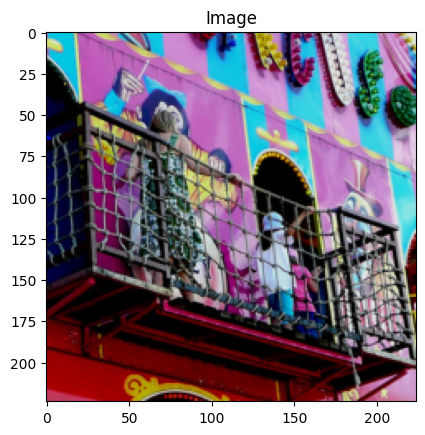

Token_ids: tensor([   2,    4,  187,   13,  188,  331,   39,    4, 1321,  124,    4,  535,
           0,   22,   17,    3])
Caption :
['<sos>', 'a', 'group', 'of', 'people', 'stand', 'on', 'a', 'balcony', 'near', 'a', 'colorful', '<unk>', 'building', '.', '<eos>']


In [49]:
img, ids = flickr_dataset[1500]
display_image(img)
print('Token_ids:', ids)
print('Caption :')
print([flickr_dataset.vocab.get_itos()[token] for token in ids.tolist()])

## Train

Dataloader is defined for the Dataset

In [50]:
batch_size = 128
pad_idx = vocab['<pad>']

data_loader = DataLoader(
    dataset =  flickr_dataset,
    batch_size = batch_size,
    shuffle = True,
    collate_fn = generate_batch_captions(pad_idx = pad_idx, batch_first = True)
)

Defining the Model Architecture.
Model is seq2seq model. In the encoder pretrained ResNet model is used to extract the features. Decoder, takes the encoder context as first input and generates the caption. In the decoder model LSTM cell is used.

Reference links for the  Seq2Seq Model-https://www.kaggle.com/code/mdteach/image-captioning-with-out-attention-pytorch

In [52]:
class EncoderCNN(nn.Module):

    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()

        resnet = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]

        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        # Generates a feature representation of size 2048
        # features shape [batch_size, 2048, 1, 1]
        features = self.resnet(images)

        # [batch_size, 2048, 1, 1] -> [batch_size, 2048]
        features = features.view(features.size(0), -1)

        # [batch_size, 2048] -> [batch_size, emb_size]
        features = self.embed(features)

        return features

In [53]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers = 1):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_size)

        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers = num_layers, batch_first = True)

        self.fcn = nn.Linear(hidden_size, vocab_size)


    def forward(self, features, captions):

        # Captions shape [batch_size, longest_text_in_batch]
        # Embeddings shape [batch_size, longest_text_in_batch, embed_size]
        # each word is represented using embedding of embed_size
        embeds = self.embedding(captions[:, :-1])

        # x shape [batch_size, longest_text_in_batch + 1, embedsize]
        # The first input to the decoder is the encoder output
        x = torch.cat((features.unsqueeze(1), embeds), dim = 1)

        x, _ = self.lstm(x)
        x = self.fcn(x)

        return x

    def generate_caption(self, inputs, hidden = None, max_len = 20, vocab = None):

        batch_size = inputs.size(0)

        captions = []

        for i in range(max_len):

            output, hidden = self.lstm(inputs, hidden)
            output = self.fcn(output)
            output = output.view(batch_size, -1)

            predicted_word_idx = output.argmax(dim = 1)
            captions.append(predicted_word_idx.item())

            if vocab.get_itos()[predicted_word_idx.item()] == '<eos>':
                break

            inputs = self.embedding(predicted_word_idx.unsqueeze(0))

        return [vocab.get_itos()[idx] for idx in captions]


Image to Captions model is defined with both encoder and decoder (without Attention).

In [54]:
class Image2Caption(nn.Module):
    def __init__(self, emb_size, hidden_size, vocab_size, num_layers = 1):
        super().__init__()

        self.encoder = EncoderCNN(emb_size)
        self.decoder = DecoderRNN(emb_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):

        features = self.encoder(images)
        outputs = self.decoder(features, captions)

        return outputs

Setting Hyperparameters for the model

In [55]:
emb_size = 300
hidden_size = 512
vocab_size = len(flickr_dataset.vocab)

num_layers = 2

learning_rate = 0.0001

Model is instantiatied with the hyperparameters. Also, Loss function and optimizers are defined.

In [56]:
model = Image2Caption(emb_size, hidden_size, vocab_size, num_layers)
model = model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])

optimizer = optim.Adam(model.parameters(), lr = learning_rate)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 159MB/s]


Training is started with Model evaluation done at every 100 steps with Images with their predicted captions displayed.

Epoch: 1 loss: 4.72441


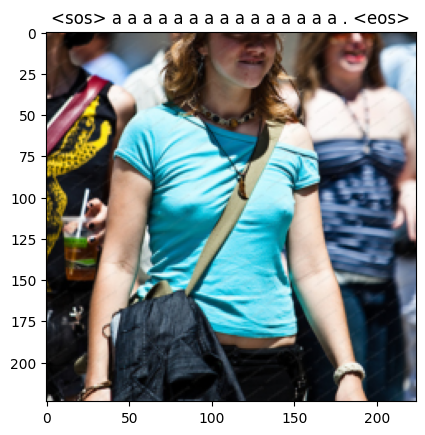

Epoch: 1 loss: 4.41077


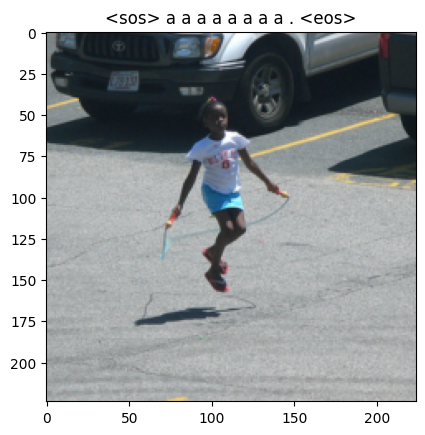

Epoch: 1 loss: 4.31979


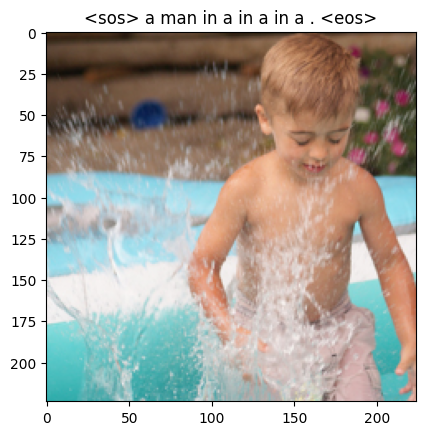

Epoch: 2 loss: 4.01036


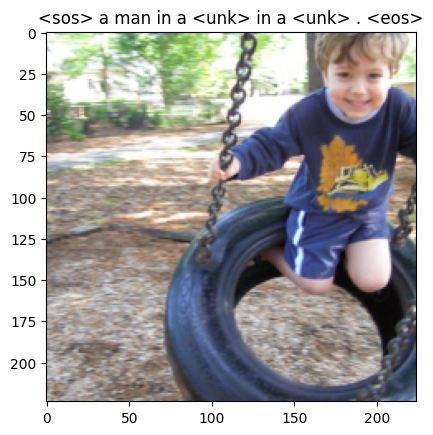

Epoch: 2 loss: 3.77767


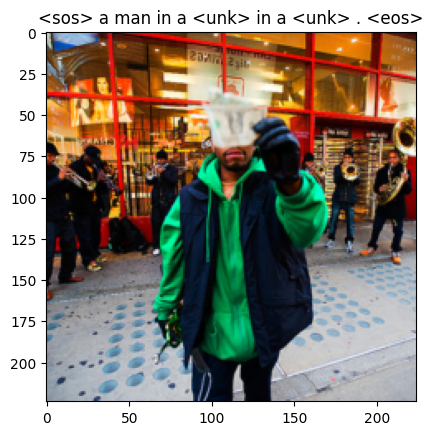

Epoch: 2 loss: 3.68033


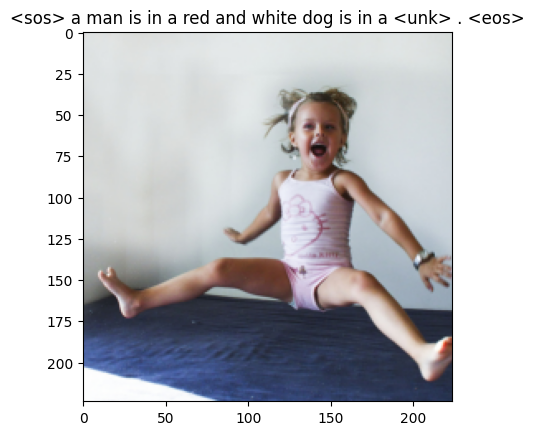

Epoch: 3 loss: 3.59087


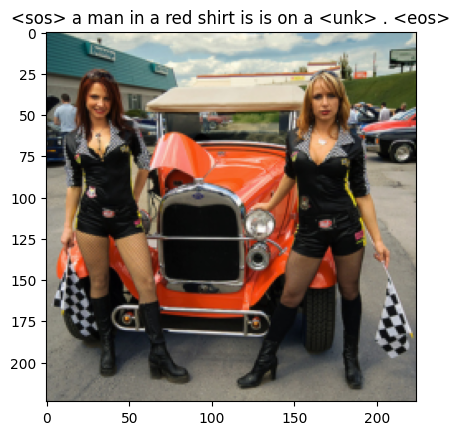

Epoch: 3 loss: 3.50009


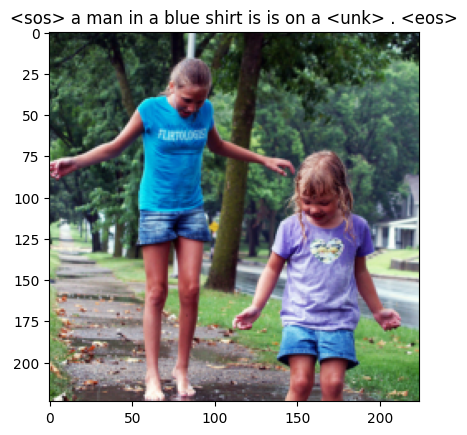

Epoch: 3 loss: 3.40101


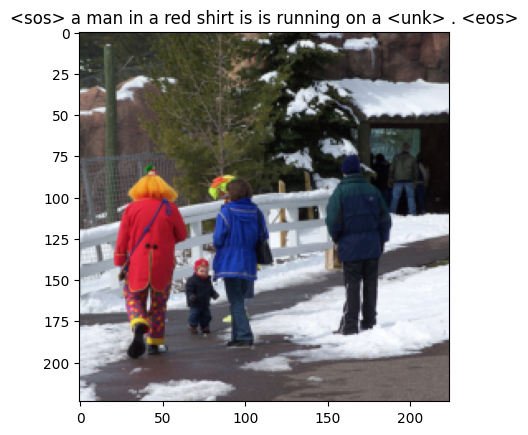

Epoch: 4 loss: 3.35293


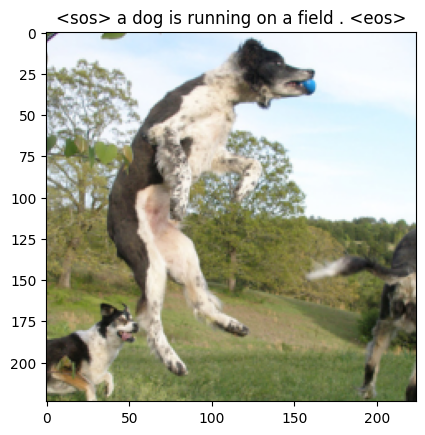

In [ ]:
num_epochs = 10
print_every = 100

for epoch in range(1, num_epochs + 1):
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image, captions = image.to(device), captions.to(device)

        optimizer.zero_grad()
        outputs = model(image, captions)

        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        loss.backward()
        optimizer.step()

        if (idx + 1) % print_every == 0:
            print('Epoch: {} loss: {:.5f}'.format(epoch, loss.item()))

            model.eval()
            with torch.no_grad():
                img, _ = next(iter(data_loader))
                features = model.encoder(img[0:1].to(device))

                caps = model.decoder.generate_caption(features.unsqueeze(0), vocab = flickr_dataset.vocab)
                caption = ' '.join(caps)

                display_image(img[0], title = caption)

            model.train()

